In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from langdetect import detect
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import nltk.corpus
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from imblearn.over_sampling import SMOTE
import seaborn as sns
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nepal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nepal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nepal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\nepal\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
data=pd.read_csv("D:/datasets/sms_span/spam.csv",encoding="ISO-8859-1")

In [3]:
data.drop(columns=data.columns[~data.columns.isin(['v1','v2'])], inplace=True)
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# cleaning data

In [4]:
print(f'Total no. of null data:\n{data.isna().sum()}')
print(f'Total no. of dupilcated data:\n{data["v2"].duplicated().sum()}')

Total no. of null data:
v1    0
v2    0
dtype: int64
Total no. of dupilcated data:
403


In [5]:
print(f'Total number of spam duplicated data: {data.loc[data["v1"]=="spam","v2"].duplicated().sum()}')
print(f'Total number of ham duplicated data: {data.loc[data["v1"]=="ham","v2"].duplicated().sum()}')

Total number of spam duplicated data: 94
Total number of ham duplicated data: 309


In [6]:
data['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

## dropping duplicated data

In [7]:
#data=data.drop_duplicates(subset='v2')
data=data.drop(data[data['v2'].duplicated()].index)

In [8]:
print(f'Total number of spam duplicated data: {data.loc[data["v1"]=="spam","v2"].duplicated().sum()}')
print(f'Total number of ham duplicated data: {data.loc[data["v1"]=="ham","v2"].duplicated().sum()}')

Total number of spam duplicated data: 0
Total number of ham duplicated data: 0


In [9]:
data['v1'].value_counts()

ham     4516
spam     653
Name: v1, dtype: int64

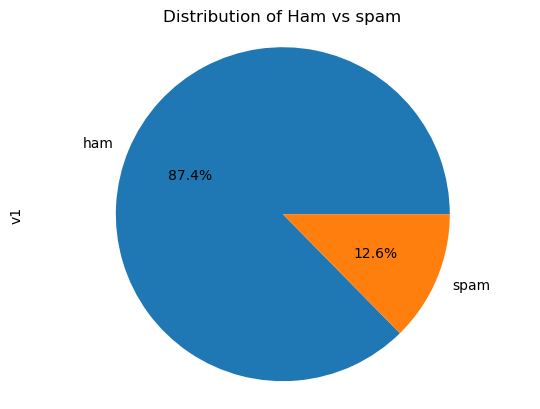

In [10]:
data['v1'].value_counts().plot(kind="pie",labels=["ham","spam"],autopct='%1.1f%%')
plt.axis('equal')
plt.title("Distribution of Ham vs spam")
plt.show()

### This is a imbalanced dataset

# Text pre-processing and Vectorization 

In [11]:
#removal of unnecessary characters
def cleaning_text(txt):
    txt= re.sub(r"http\S+", '', txt) # remove URL
    txt = re.sub(r'https?://\S+', '', txt) #remove URL
    txt= re.sub(r"@\S+", '', txt) # remove twitter handle
    # txt= re.sub(r"\d+", '', txt) #remove numbers
    txt= re.sub(r"[^a-zA-Z ]", '',txt) # keep only letters and spaces (remove digits and characters)
    txt= re.sub(r"\s[\s]+", '', txt) # Delete more than one spaces
    txt= txt.lower()
    return txt

In [12]:
data['v2']=data['v2'].apply(cleaning_text)

In [13]:
# lemmetization and tf_idf
stop_words = nltk.corpus.stopwords.words("english")
lemmatizer= WordNetLemmatizer()

def preprocess(text):
    tokens= word_tokenize(text,language="english")
    filtered_tokens= [word for word in tokens if word not in stop_words]
    lemmatized_tokens= [lemmatizer.lemmatize(word) for word in filtered_tokens]
    preprocess_text= ' '.join(lemmatized_tokens)
    return preprocess_text

In [14]:
data['v2']=data['v2'].apply(preprocess)

In [15]:
data.head(5)

,v1,v2
0,ham,go jurong point crazy available bugis n great ...
1,ham,ok lar joking wif u oni
2,spam,free entry ina wkly comp win fa cup final tkts...
3,ham,u dun say early hor u c already say
4,ham,nah dont think go usf life around though


In [16]:
##Apply TF-IDF in preprocessed text
tfidf=TfidfVectorizer(ngram_range=(1,1),min_df=2)
transformed_data = tfidf.fit_transform(data['v2']) 

# split into test and train dataset

In [17]:
x,y=resample(transformed_data,data['v1'])
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [18]:
print(y_train.value_counts())
print('\n')
print(y_test.value_counts())

ham     3608
spam     527
Name: v1, dtype: int64


ham     903
spam    131
Name: v1, dtype: int64


# Balancing the train_dataset by SMOTE 

In [19]:
x_trains,y_trains=SMOTE().fit_resample(x_train,y_train)

# Building Model

Model: LogisticRegression
----------------------------------------
test recall: 0.6717557251908397
test precision: 1.0
test accuracy: 0.9584139264990329
f1_score: 0.8036529680365296


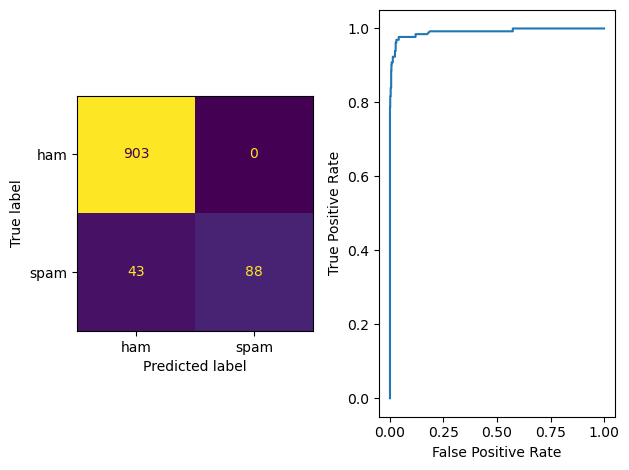



Model: RandomForestClassifier
----------------------------------------
test recall: 0.9083969465648855
test precision: 1.0
test accuracy: 0.988394584139265
f1_score: 0.9520000000000001


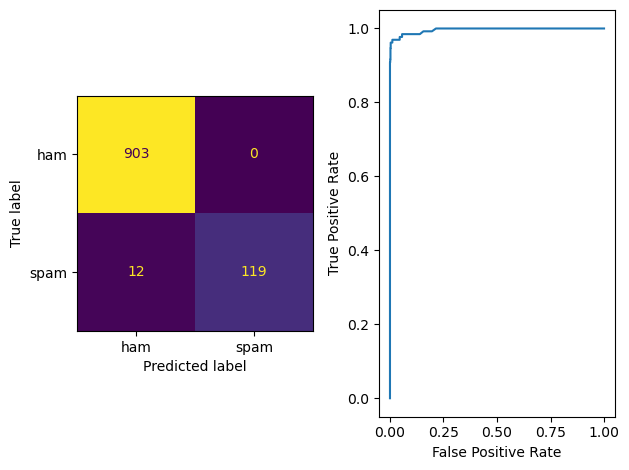



Model: MultinomialNB
----------------------------------------
test recall: 0.7633587786259542
test precision: 1.0
test accuracy: 0.9700193423597679
f1_score: 0.8658008658008659


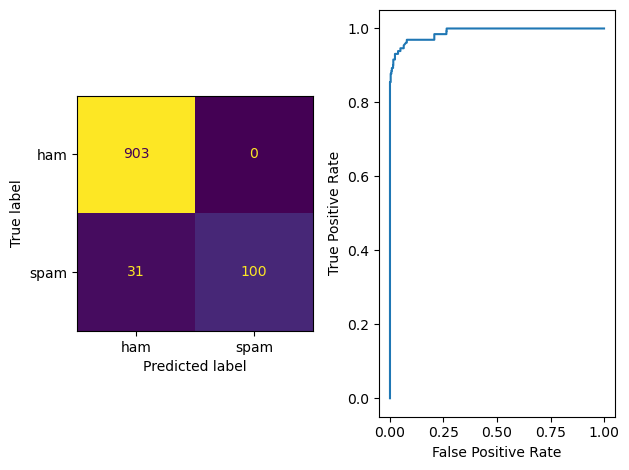

In [20]:
#using imbalanced data for training
models=[LogisticRegression(),RandomForestClassifier(),MultinomialNB()]
for model in models:
    model.fit(x_train,y_train)
    model.predict(x_test)
    y_pred=model.predict(x_test)
    print(f'Model: {type(model).__name__}')
    print("--"*20)
    print(f'test recall: {recall_score(y_test,y_pred,pos_label="spam")}')
    print(f'test precision: {precision_score(y_test,y_pred,pos_label="spam")}')
    print(f'test accuracy: {accuracy_score(y_test,y_pred)}')
    print(f'f1_score: {f1_score(y_test,y_pred,pos_label="spam")}')
    fig,axs=plt.subplots(1,2)
    cm=confusion_matrix(y_test,y_pred)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
    cmd.plot(colorbar=False,ax=axs[0])
    y_proba = model.predict_proba(x_test)
    fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1],pos_label="spam")
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axs[1])
    plt.tight_layout()
    plt.show()
    print("\n")

#### We want to detect spam emails. Recall is sensitive parameter here
#### With imbalanced data, Random forest classifier has best performance(recall=0.90) followed by Multi Nominal Bias(recall=0.76). 
#### The performance of Logistic regression is poor(recall=0.67).  with imbalanced dataset, model is highly biased.

Model: LogisticRegression
----------------------------------------
test recall: 0.9312977099236641
test precision: 0.9104477611940298
test accuracy: 0.9796905222437138
f1_score: 0.9207547169811321


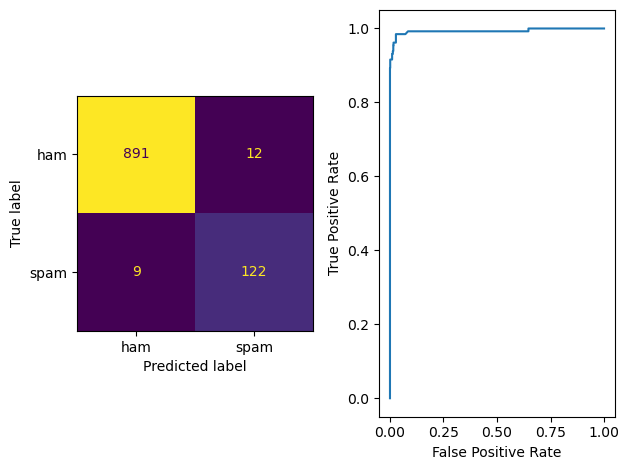



Model: RandomForestClassifier
----------------------------------------
test recall: 0.9007633587786259
test precision: 1.0
test accuracy: 0.9874274661508704
f1_score: 0.9477911646586346


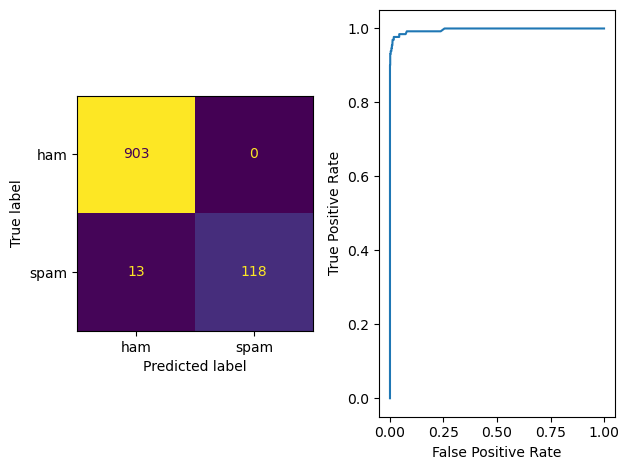



Model: MultinomialNB
----------------------------------------
test recall: 0.9389312977099237
test precision: 0.82
test accuracy: 0.9661508704061895
f1_score: 0.8754448398576513


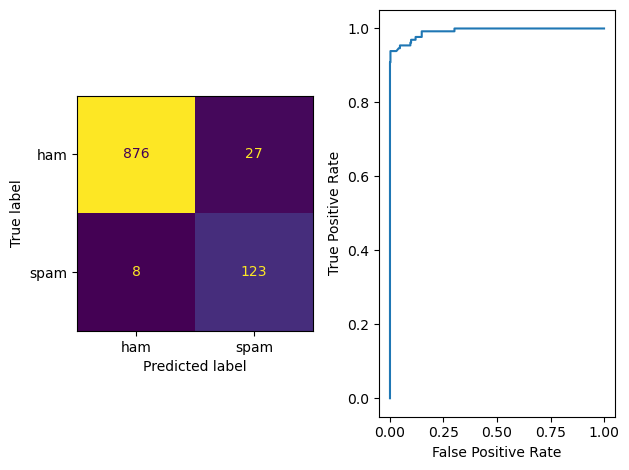

In [21]:
#using randomoversampled data for training
#using imbalanced data for training
models=[LogisticRegression(),RandomForestClassifier(),MultinomialNB()]
for model in models:
    model.fit(x_trains,y_trains)
    model.predict(x_test)
    y_pred=model.predict(x_test)
    print(f'Model: {type(model).__name__}')
    print("--"*20)
    print(f'test recall: {recall_score(y_test,y_pred,pos_label="spam")}')
    print(f'test precision: {precision_score(y_test,y_pred,pos_label="spam")}')
    print(f'test accuracy: {accuracy_score(y_test,y_pred)}')
    print(f'f1_score: {f1_score(y_test,y_pred,pos_label="spam")}')
    fig,axs=plt.subplots(1,2)
    cm=confusion_matrix(y_test,y_pred)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
    cmd.plot(colorbar=False,ax=axs[0])
    y_proba = model.predict_proba(x_test)
    fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1],pos_label="spam")
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axs[1])
    plt.tight_layout()
    plt.show()
    print("\n")

#### With balanced train dataset, the performance of logistic Regression has drastically improved (recall=0.93). Model is not biased for any class. 
#### Oversampling of a train data doesnot make any change in model performance of randomforest classifier.